In [90]:
## Imports

# General
import os
import os.path as path
import json
from glob import glob
import numpy as np
import cv2
import pandas as pd
from PIL import Image, ImageDraw
from scipy.spatial import distance
from ipynb.fs.full.shared_code import distance_panoramic
import matplotlib.pyplot as plt

%matplotlib inline

In [168]:
# Set data to be processed
DROOT = './0_data'

# Sources
EYE_SRC = path.join(DROOT, "2_procfootage/eyetracker/")
EYE_LBL = path.join(DROOT, "2_procfootage/eyetracker/labels.csv")
RND_SRC = path.join(DROOT, "2_procfootage/round_img/")
RND_LBL = path.join(DROOT, "2_procfootage/round_img/labels.csv")

MAP_SFT = path.join(DROOT, "3_sift/mapping.csv")
MAP_SNN = path.join(DROOT, "4_simsiam/mapping.csv")

# Destination
MAP_DST = path.join(DROOT, "5_paper_figures/4-res-comparisons.png")
DEV_DST = path.join(DROOT, "5_paper_figures/4-res-deviation-distribution.png")

In [97]:
# Get scores and files
labels_frame = pd.read_csv(EYE_LBL, index_col='frame')
labels_sift = pd.read_csv(MAP_SFT, index_col='frame_id')
labels_snn = pd.read_csv(MAP_SNN, index_col='frame_id')

# Get scoring mechanism
true = labels_frame[['true_x', 'true_y']].to_numpy()
base = labels_frame[['base_x', 'base_y']].to_numpy()
sift = labels_sift[['base_x_est', 'base_y_est']].to_numpy()
snn  = labels_snn [['base_x_est', 'base_y_est']].to_numpy()

# Score amount of frames of difference
max_dst = distance.euclidean((0,0), (181,181))
sc_base = [distance_panoramic(true, base, 5792) / max_dst for true, base in zip(true, base)]
sc_sift = [distance_panoramic(true, sift, 5792) / max_dst for true, sift in zip(true, sift)]
sc_snn  = [distance_panoramic(true, snn,  5792) / max_dst for true, snn  in zip(true, snn)]

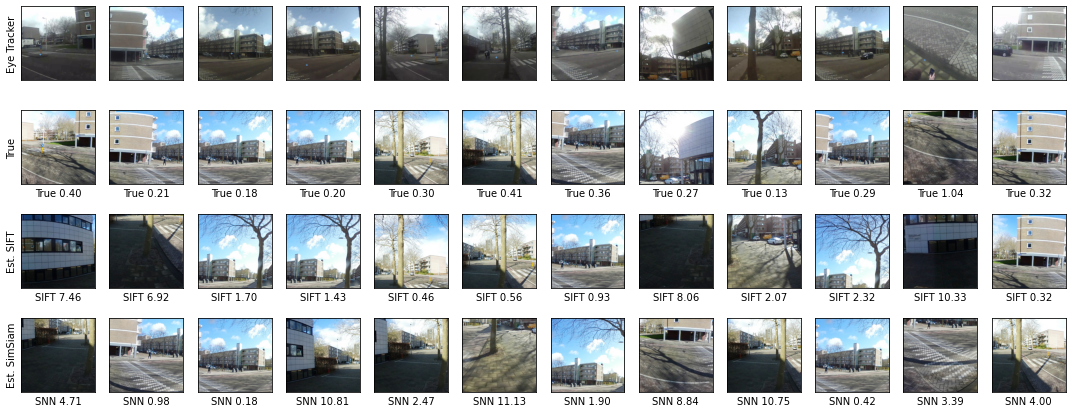

In [104]:
fig, axs = plt.subplots(ncols=12, nrows=4, figsize=(15, 6), )

frameids = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]

axs[0][0].set_ylabel('Eye Tracker')
axs[1][0].set_ylabel('True')
axs[2][0].set_ylabel('Est. SIFT')
axs[3][0].set_ylabel('Est. SimSiam')

for i in range(len(frameids)):
    for r in range(4):
        axs[r][i].axes.xaxis.set_ticks([])
        axs[r][i].axes.yaxis.set_ticks([])
    
    base_id = labels_frame.iloc[frameids[i]].base_id.astype(int)
    base_id_sift_est = labels_sift.iloc[frameids[i]].base_id_est
    base_id_snn_est  = labels_snn .iloc[frameids[i]].base_id_est
    
    axs[0][i].imshow(plt.imread(path.join(EYE_SRC, f"{frameids[i]}.png")))
    
    axs[1][i].imshow(plt.imread(path.join(RND_SRC, f"{base_id}.png")))
    axs[1][i].set_xlabel(fr"True {(sc_base[frameids[i]]):.2f}")
    
    axs[2][i].imshow(plt.imread(path.join(RND_SRC, f"{base_id_sift_est}.png")))
    axs[2][i].set_xlabel(fr"SIFT {(sc_sift[frameids[i]]):.2f}")
    
    axs[3][i].imshow(plt.imread(path.join(RND_SRC, f"{base_id_snn_est}.png")))
    axs[3][i].set_xlabel(fr"SNN {(sc_snn[frameids[i]]):.2f}")

fig.tight_layout()

### Score Distribution

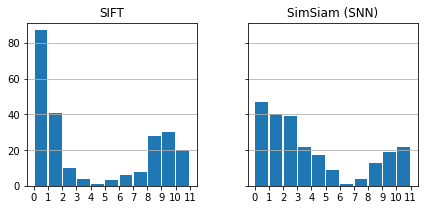

In [171]:
data = pd.DataFrame({'SIFT': sc_sift, 'SimSiam (SNN)': sc_snn})

fig, axs = plt.subplots(ncols=2, figsize=(7, 3), sharey=True)
data.hist(align='mid', bins=list(range(0, 12)),rwidth=0.9, ax=axs)
axs[0].axes.xaxis.set_ticks(range(12))
axs[1].axes.xaxis.set_ticks(range(12))
axs[0].grid(False, axis='x')
axs[1].grid(False, axis='x')

fig.savefig(DEV_DST)